In [5]:
pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 12.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done


  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16300 sha256=8d28fcb01a1eb946670b78502f7048588fde06d8818fca161c129cf708c9e639
  Stored in directory: /Users/eesoonhang/Library/Caches/pip/wheels/2b/5e/f2/3931524f702ffd03309e96d35ee2fbf9c61c27377511ee8d4c
Successfully built swifter
Note: you may need to restart the kernel to use updated packages.


In [43]:
# import packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import pandas as pd
import numpy as np
import swifter

import seaborn as sns
import matplotlib.pyplot as plt

import great_expectations as ge

In [2]:
# import data
train_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_in_encodedToNacSeq.csv', usecols=lambda x: x != '*Unnamed*')
train_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_out.csv', usecols=lambda x: x != '*Unnamed*')

In [4]:
train_X.head()

,A,C,G,T,AA,AC,AG,AT,CA,CC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,187,363,289,162,36,60,59,32,67,144,...,13,12,11,16,17,5,2,11,9,3
1,257,220,225,299,73,49,64,70,71,62,...,3,22,25,15,32,12,24,18,18,42
2,271,239,214,277,83,56,75,57,92,53,...,1,28,24,27,14,16,16,23,17,26
3,301,193,231,276,116,47,82,56,72,48,...,4,19,22,15,20,22,22,15,16,36
4,324,135,210,332,123,36,71,94,47,29,...,2,17,20,16,23,21,28,19,25,53


In [5]:
train_y.head()

,hAm,hCm,hGm,hTm,hm1A,hm5C,hm5U,hm6A,hm6Am,hm7G,hPsi,Atol
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# compress train_y from 12 classes to 1
# build a model that could only identify modified or non-modified
compressed_y = train_y.sum(axis=1).to_frame(name='target')

In [22]:
compressed_y.value_counts()

target
1.0       152448
0.0       152208
2.0            5
dtype: int64

In [32]:
# transform target >=1 to 1
def normalize_output(x):
    return np.where(x.target>1, x.target/x.target, x.target)

%time compressed_y.target = compressed_y.swifter.apply(normalize_output, axis=1)

CPU times: user 48.4 ms, sys: 3.57 ms, total: 51.9 ms
Wall time: 50.8 ms


In [42]:
compressed_y.value_counts()

target
1.0       152453
0.0       152208
dtype: int64

In [47]:
df = pd.concat([train_X, compressed_y], axis=1)
df.head()

,A,C,G,T,AA,AC,AG,AT,CA,CC,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,target
0,187,363,289,162,36,60,59,32,67,144,...,12,11,16,17,5,2,11,9,3,1.0
1,257,220,225,299,73,49,64,70,71,62,...,22,25,15,32,12,24,18,18,42,1.0
2,271,239,214,277,83,56,75,57,92,53,...,28,24,27,14,16,16,23,17,26,1.0
3,301,193,231,276,116,47,82,56,72,48,...,19,22,15,20,22,22,15,16,36,1.0
4,324,135,210,332,123,36,71,94,47,29,...,17,20,16,23,21,28,19,25,53,1.0


In [60]:
# compute Pearson Correlation
# display coeff against y-value that is >0.7 (strongly correlated)
cor = df.corr()
cor_target = abs(cor["target"])
#Selecting highly correlated features
sorted_cor = cor_target.sort_values(ascending=True)
print(sorted_cor)

AGA       0.000762
TC        0.002415
AAC       0.019931
CT        0.028428
TG        0.031779
            ...   
TAG       0.283634
CGA       0.284160
TA        0.296298
ATT       0.296375
target    1.000000
Name: target, Length: 85, dtype: float64


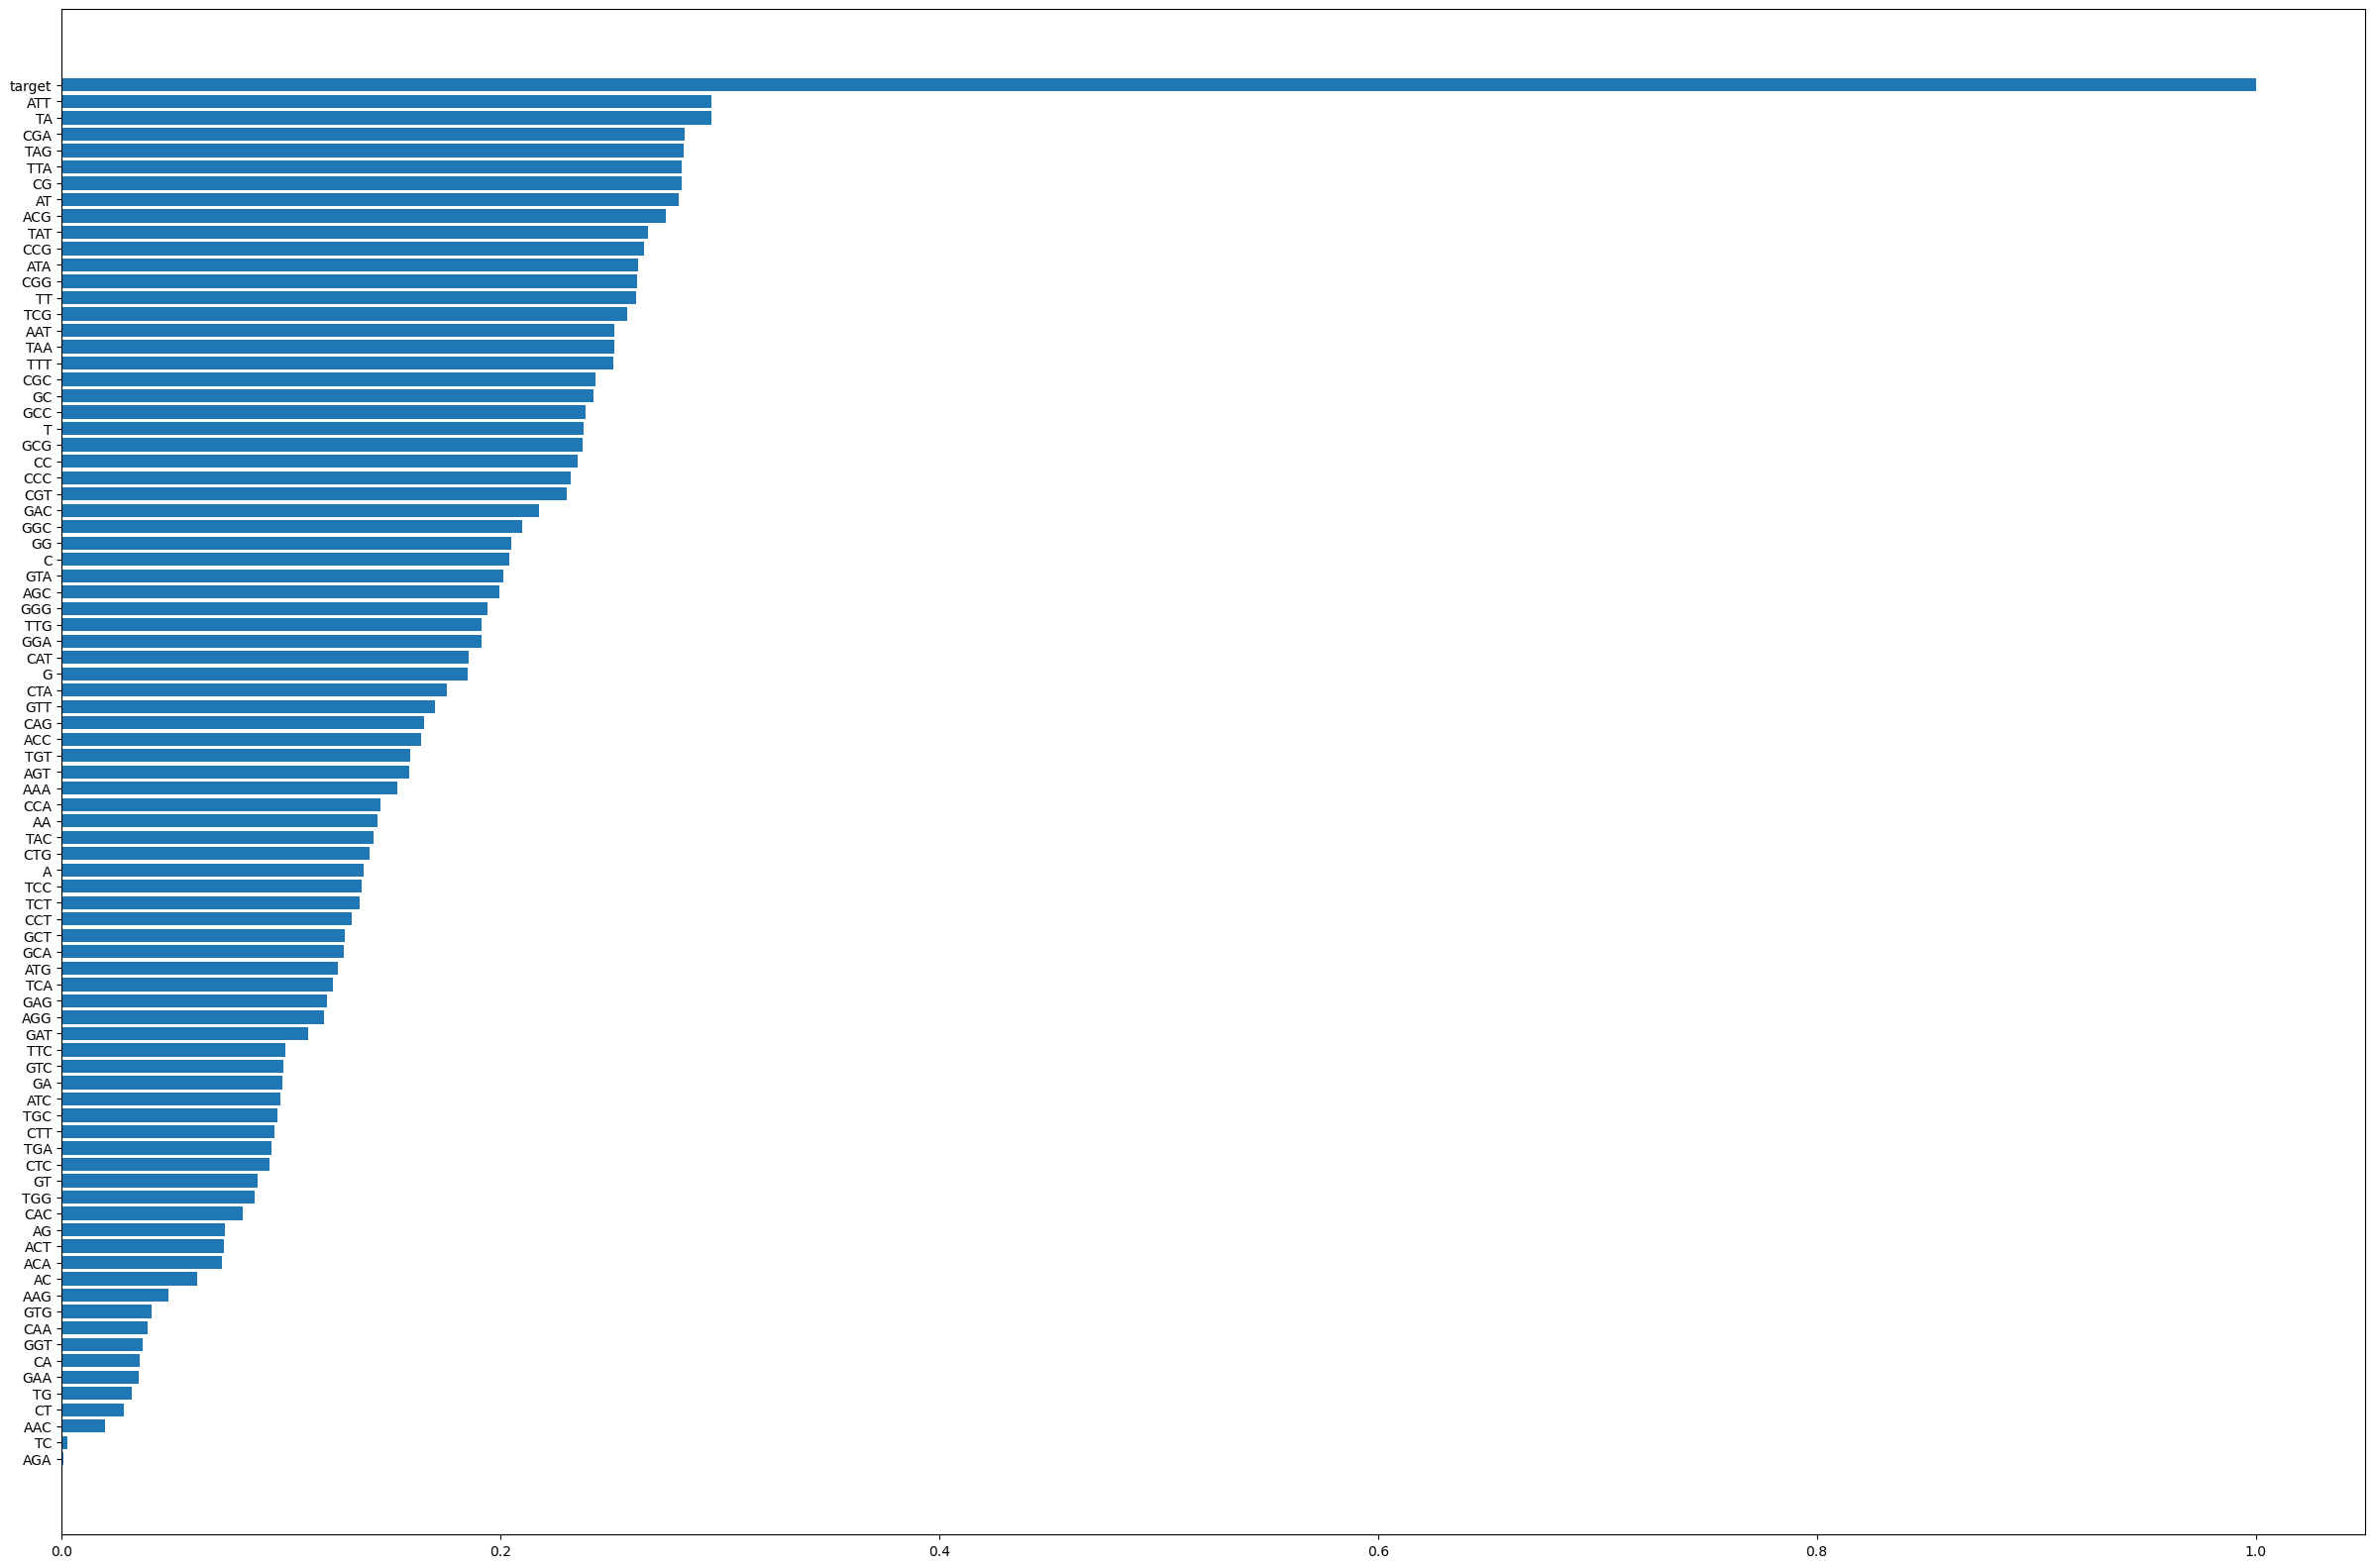

In [64]:
plt.figure(figsize=(30,20))
plt.barh(sorted_cor.index, sorted_cor)
plt.show()

In [66]:
# check multicollinearity between the variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.tools.tools as smt

In [68]:
train_X_nac = train_X.iloc[:, 0:4]
train_X_dac = train_X.iloc[:, 4:20]
train_X_tac = train_X.iloc[:, 20:]

In [70]:
train_X_nac.head()

,A,C,G,T
0,187,363,289,162
1,257,220,225,299
2,271,239,214,277
3,301,193,231,276
4,324,135,210,332


In [84]:
sample = ['A', 'B', 'C', 'D']
dict(zip(sample, [0]*len(sample)))

{'A': 0, 'B': 0, 'C': 0, 'D': 0}


In [113]:
def compute_vif(data):
    data_c = smt.add_constant(data=data, prepend=False)
    label = [label for idx, label in enumerate(data.columns.tolist())]
    index = [idx for idx, label in enumerate(data.columns.tolist())]
    vif = [variance_inflation_factor(exog=data_c.values, exog_idx=idx) for idx in index]
    return dict(zip(label, vif))

          A         C         G         T
A  1.803035  0.417461 -0.502088 -1.163129
C  0.417461  2.890279 -2.346516 -0.350487
G -0.502088 -2.346516  2.927254  0.305210
T -1.163129 -0.350487  0.305210  1.759613


<AxesSubplot:>

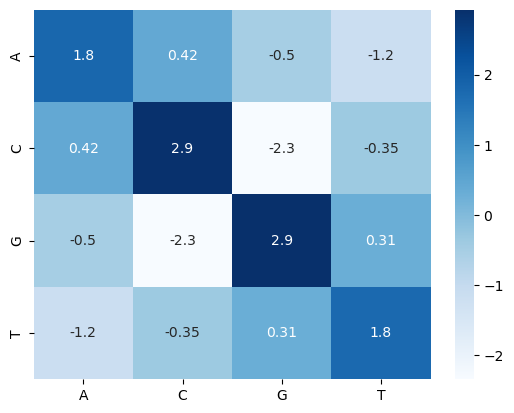

In [72]:
# display VIF along diagonal edge for variables extracted via NAC
train_X_nac_cor = np.linalg.inv(a = train_X_nac.corr())
train_X_nac_cor = pd.DataFrame(data=train_X_nac_cor, index=train_X_nac.columns, columns=train_X_nac.columns)
print(train_X_nac_cor)
sns.heatmap(data=train_X_nac_cor, cmap="Blues", annot=True)

# Code below compute VIF for nacSeq-1 extracted dataset

In [90]:
# compute vif for NAC extracted dataset
sorted(compute_vif(train_X_nac).items(), key=lambda x: x[1], reverse=True)

[('G', 2.9272544758652645),
 ('C', 2.890279184083295),
 ('A', 1.803034827965035),
 ('T', 1.7596125636058704)]

# Code below compute VIF for nacSeq-2 extracted dataset

In [89]:
# initial compute
sorted(compute_vif(train_X_dac).items(), key=lambda x: x[1], reverse=True)

[('GC', 2768.4757931310437),
 ('AT', 2080.320392049609),
 ('TA', 1952.741412274582),
 ('CG', 1836.1779066391641),
 ('CT', 1570.3979018328996),
 ('AG', 1506.1074159444697),
 ('TG', 1497.9287811621425),
 ('CA', 1322.1276221551218),
 ('GA', 1252.6740705859359),
 ('TC', 1086.4968395117796),
 ('GT', 807.2132204869149),
 ('AC', 755.5130946829966),
 ('CC', 6.044561697134879),
 ('GG', 5.500282075996531),
 ('TT', 4.006318570176775),
 ('AA', 3.790851985060124)]

In [92]:
# remove the variable with the highest VIF where (VIF>10)
# then recompute VIF
train_X_dac_m = train_X_dac.drop('GC', axis=1)
sorted(compute_vif(train_X_dac_m).items(), key=lambda x: x[1], reverse=True)

[('AT', 2080.3007134368854),
 ('TA', 1952.7260112915205),
 ('CT', 1114.1148363616226),
 ('TG', 1092.404956452158),
 ('AG', 1091.716345290928),
 ('CA', 927.459353161711),
 ('GA', 908.9430171736708),
 ('TC', 771.1512359905089),
 ('GT', 589.236063534662),
 ('AC', 530.2560584272724),
 ('CC', 6.044289467392851),
 ('GG', 5.499484188989928),
 ('CG', 4.058551670615654),
 ('TT', 4.006315046259891),
 ('AA', 3.7908507342724387)]

In [94]:
# remove the variable with the second highest VIF where (VIF>10)
train_X_dac_m = train_X_dac.drop(['GC', 'AT'], axis=1)
sorted(compute_vif(train_X_dac_m).items(), key=lambda x: x[1], reverse=True)

[('AG', 788.3935639215595),
 ('CT', 780.2514586153536),
 ('TG', 764.0549167920215),
 ('CA', 669.7390267378186),
 ('GA', 656.5099700363207),
 ('TC', 539.512729323011),
 ('GT', 413.1994223549517),
 ('AC', 383.6943154353542),
 ('CC', 6.04398129159519),
 ('GG', 5.4990565508773),
 ('TA', 5.113076102619986),
 ('CG', 4.058203552687065),
 ('TT', 4.0026758615061855),
 ('AA', 3.788454259187408)]

In [95]:
# remove the variable with the third highest VIF where (VIF>10)
train_X_dac_m = train_X_dac.drop(['GC', 'AT', 'AG'], axis=1)
sorted(compute_vif(train_X_dac_m).items(), key=lambda x: x[1], reverse=True)

[('CT', 13.022228634227798),
 ('TC', 9.802309035608618),
 ('TG', 9.799325434744468),
 ('CA', 7.6287782693381),
 ('AC', 6.436745217133358),
 ('GT', 6.314946685285326),
 ('CC', 6.04310084746327),
 ('GG', 5.492738103214015),
 ('TA', 5.110947664776456),
 ('CG', 4.057191566256296),
 ('TT', 4.002674798691787),
 ('AA', 3.788280647516174),
 ('GA', 3.344959366182643)]

In [96]:
# remove the variable with the forth highest VIF where (VIF>10)
train_X_dac_m = train_X_dac.drop(['GC', 'AT', 'AG', 'CT'], axis=1)
sorted(compute_vif(train_X_dac_m).items(), key=lambda x: x[1], reverse=True)

[('TG', 6.061810260245846),
 ('CA', 5.462421189892294),
 ('CC', 5.4002226388085965),
 ('TA', 5.037926577912257),
 ('GG', 4.99497563014766),
 ('GT', 4.943237383822588),
 ('AC', 4.671806757452589),
 ('TT', 4.000600605949454),
 ('AA', 3.7796003238599876),
 ('CG', 3.559911386325036),
 ('GA', 3.1818651238742737),
 ('TC', 3.1135209324522903)]

# Code below compute VIF for nacSeq-3 extracted dataset

In [97]:
# initial compute
sorted(compute_vif(train_X_tac).items(), key=lambda x: x[1], reverse=True)

[('GCG', 2682.7525937985242),
 ('CGC', 2602.841582858927),
 ('CGG', 2543.0502927897055),
 ('CCG', 2490.8756077202747),
 ('GCC', 2022.7382338428795),
 ('GGC', 1895.1933282647174),
 ('TAT', 1599.1261002777887),
 ('ATA', 1495.7205764120292),
 ('ATT', 1381.8545764460264),
 ('AAT', 1259.3948419440421),
 ('CCT', 1225.363259319403),
 ('TTA', 1157.8873577770491),
 ('CTG', 1130.724839977206),
 ('AGG', 1083.4626839767557),
 ('CTC', 1072.2569969707029),
 ('GAG', 1067.9585052062855),
 ('TGT', 1043.471376491604),
 ('TAA', 1024.9203068335687),
 ('AGA', 1011.8180919661438),
 ('CAG', 1006.0739595232916),
 ('TGG', 946.6237865625604),
 ('TCT', 944.1107792082817),
 ('TCC', 942.4006638792498),
 ('GGA', 918.3290085555423),
 ('CCA', 914.7931665880183),
 ('ACA', 876.8452600365888),
 ('GTG', 845.7940995925177),
 ('GAA', 787.3785491309642),
 ('CAC', 786.4586938591563),
 ('AGC', 742.0942045622015),
 ('TTC', 709.6418856830048),
 ('AAG', 708.6330207830097),
 ('GCT', 689.290807214309),
 ('CTT', 645.4823327193541),

In [99]:
# remove the variable with the highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop('GCG', axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('GCC', 1756.692696254613),
 ('GGC', 1643.416216267971),
 ('TAT', 1599.125765650934),
 ('ATA', 1495.7201411421067),
 ('ATT', 1381.853671835479),
 ('AAT', 1259.3947640658946),
 ('CCT', 1225.3597594047608),
 ('TTA', 1157.8855638823602),
 ('CTG', 1130.7196485824593),
 ('AGG', 1083.4516774896688),
 ('CTC', 1072.2569111866962),
 ('GAG', 1067.958060435881),
 ('TGT', 1043.4694585557613),
 ('TAA', 1024.9202631556493),
 ('CGG', 1018.1633327418142),
 ('AGA', 1011.8176210563704),
 ('CCG', 1009.4215512556314),
 ('CAG', 1006.0733994181817),
 ('TGG', 946.6075100217652),
 ('TCT', 944.1107761955681),
 ('TCC', 942.3973290584137),
 ('GGA', 918.3241841647448),
 ('CCA', 914.7816620287246),
 ('ACA', 876.8391353449883),
 ('GTG', 845.7922144610937),
 ('GAA', 787.3701415037025),
 ('CAC', 786.4533012891625),
 ('TTC', 709.6382201926199),
 ('AAG', 708.6284363477122),
 ('CTT', 645.4782633000943),
 ('AGC', 638.0693225026591),
 ('TTG', 625.0059048725527),
 ('ACC', 598.4913546965234),
 ('GCT', 592.3745431440976),
 

In [100]:
# remove the variable with the second highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('TAT', 1599.1250156961328),
 ('ATA', 1495.7196384694917),
 ('ATT', 1381.8520075767299),
 ('GGC', 1265.4261648601523),
 ('AAT', 1259.394185018545),
 ('TTA', 1157.8850466661506),
 ('CTG', 1130.7175313131859),
 ('AGG', 1083.449681563621),
 ('CTC', 1072.2565850154883),
 ('GAG', 1067.956105861985),
 ('TGT', 1043.4694413608233),
 ('TAA', 1024.920262588037),
 ('AGA', 1011.8157345683034),
 ('CAG', 1006.067574199471),
 ('TGG', 946.606553304905),
 ('TCT', 944.1105122161593),
 ('GGA', 918.3241219014099),
 ('CCT', 879.4488691571971),
 ('ACA', 876.8381534729346),
 ('GTG', 845.7921583772713),
 ('GAA', 787.3681426730996),
 ('CGG', 786.6728029536168),
 ('CAC', 786.4522271329249),
 ('TTC', 709.638220183283),
 ('AAG', 708.6221150212424),
 ('TCC', 703.9983116247514),
 ('CTT', 645.4781082276467),
 ('CCA', 640.3391580207798),
 ('TTG', 625.0057623870358),
 ('ATG', 581.3351740078085),
 ('TGA', 566.8551450765002),
 ('GTT', 521.3662822748082),
 ('TCA', 518.0810034921032),
 ('AAC', 511.3531168659408),
 ('CAT'

In [101]:
# remove the variable with the third highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('GGC', 1265.4261521966775),
 ('CTG', 1130.7171639326248),
 ('AGG', 1083.4481510404912),
 ('CTC', 1072.253627405354),
 ('GAG', 1067.9392739390175),
 ('TGT', 1043.469421548017),
 ('AGA', 1011.7979979858131),
 ('CAG', 1006.0472269969574),
 ('ATT', 978.474897684486),
 ('TGG', 946.6061079280987),
 ('TCT', 944.1074428396997),
 ('GGA', 918.2974889439454),
 ('AAT', 882.0051603881018),
 ('CCT', 879.4450588269449),
 ('ACA', 876.8284091078561),
 ('GTG', 845.7919054337689),
 ('TTA', 825.4429108199442),
 ('GAA', 787.3678294128415),
 ('CGG', 786.6726727261049),
 ('CAC', 786.4445556614432),
 ('TAA', 729.1899584780747),
 ('TTC', 709.6370371460702),
 ('AAG', 708.6115339255336),
 ('TCC', 703.9982966030994),
 ('CTT', 645.4780285537508),
 ('CCA', 640.3041043404371),
 ('TTG', 625.0057388765897),
 ('TGA', 566.8423006551099),
 ('GTT', 521.365905424237),
 ('TCA', 518.0624129007668),
 ('AAC', 511.3501812472883),
 ('ACT', 494.24639836432846),
 ('AGT', 489.329740458119),
 ('GGT', 483.1162041927051),
 ('AGC', 4

In [102]:
# remove the variable with the forth highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('CTG', 1130.7095657895059),
 ('CTC', 1072.2535053671445),
 ('GAG', 1067.936441338435),
 ('TGT', 1043.4625965182888),
 ('AGA', 1011.7960039479665),
 ('CAG', 1006.0438974943097),
 ('ATT', 978.4714998246835),
 ('TCT', 944.1074087755158),
 ('AAT', 882.0036644440382),
 ('ACA', 876.8255725072714),
 ('GTG', 845.7859284543845),
 ('TTA', 825.439850679634),
 ('GAA', 787.3672811731112),
 ('CAC', 786.44197387817),
 ('CCT', 775.9686092198725),
 ('TAA', 729.1882631050805),
 ('TTC', 709.6361275966757),
 ('AAG', 708.6095129671961),
 ('AGG', 694.3082931599882),
 ('CTT', 645.4774800569157),
 ('TCC', 632.749785103651),
 ('TTG', 625.0045194471493),
 ('TGG', 596.7943289224432),
 ('GGA', 590.4693607595585),
 ('TGA', 566.8422560372196),
 ('CCA', 557.7058267701664),
 ('GTT', 521.3649853218138),
 ('TCA', 518.0609561907057),
 ('AAC', 511.348404786584),
 ('ACT', 494.2411974996289),
 ('AGT', 489.3242421420857),
 ('CAA', 470.75143980634135),
 ('ATG', 428.30730118758964),
 ('AGC', 422.56813787186053),
 ('ACC', 42

In [103]:
# remove the variable with the forth highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('GAG', 1067.9364346743173),
 ('AGA', 1011.7960018800911),
 ('CAG', 1006.0414230403915),
 ('ATT', 978.4662723007873),
 ('AAT', 882.0036644240009),
 ('ACA', 876.825340449616),
 ('TGT', 834.1277205918238),
 ('CTC', 830.3446121879794),
 ('TTA', 825.4357789241251),
 ('GAA', 787.3616183693167),
 ('CAC', 786.4416831757517),
 ('TCT', 730.7850372744819),
 ('TAA', 729.1882628538982),
 ('TTC', 709.6358633634966),
 ('AAG', 708.6047959475028),
 ('AGG', 694.306896203791),
 ('GTG', 676.4438664268723),
 ('TCC', 632.7478513747122),
 ('GGA', 590.4676545474925),
 ('CCA', 557.7056291345187),
 ('GTT', 521.3625300513526),
 ('TCA', 518.0601241256157),
 ('AAC', 511.3482204821123),
 ('CCT', 493.0639593308501),
 ('AGT', 489.3208324080258),
 ('CAA', 470.7504502679071),
 ('CTT', 459.6489746519575),
 ('TTG', 458.09659157794636),
 ('TGA', 433.97183927921657),
 ('AGC', 422.56645869151976),
 ('ACC', 422.1707763683791),
 ('GAC', 399.3032555026083),
 ('ACT', 394.80218384701226),
 ('TGG', 393.99947534503525),
 ('CAT',

In [104]:
# remove the variable with the fifth highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('ATT', 978.4635133479266),
 ('AAT', 882.0013537785167),
 ('ACA', 876.8181996157087),
 ('TGT', 834.1253771136005),
 ('CTC', 830.3446005322766),
 ('TTA', 825.4309267508598),
 ('CAC', 786.4354611094325),
 ('CAG', 735.5515252503957),
 ('TCT', 730.7850050508958),
 ('TAA', 729.1869647388755),
 ('TTC', 709.6326432426652),
 ('GTG', 676.4430319845169),
 ('TCC', 632.7455380164464),
 ('GAA', 562.8974569249564),
 ('CCA', 557.681514044804),
 ('GTT', 521.3622416732919),
 ('TCA', 518.0545552014875),
 ('AAC', 511.33857940375594),
 ('AAG', 503.62710651364296),
 ('CCT', 493.0614801283364),
 ('CAA', 470.74942442181697),
 ('CTT', 459.64636069322586),
 ('TTG', 458.0933043501651),
 ('AGG', 449.82310573614706),
 ('ACC', 422.1695423296073),
 ('ACT', 394.802182788696),
 ('TGG', 393.99780972283435),
 ('AGT', 384.37491782685134),
 ('GGA', 378.68704250754934),
 ('CAT', 359.9004502605081),
 ('GGT', 331.2347946187134),
 ('GTC', 330.82069586325014),
 ('GAC', 320.4128802013478),
 ('GTA', 305.51535801007606),
 ('GCA

In [105]:
# remove the variable with the fifth highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('ACA', 876.8155502393595),
 ('TGT', 834.1248544197018),
 ('CTC', 830.3434403966234),
 ('CAC', 786.433099185565),
 ('CAG', 735.5503232156121),
 ('AAT', 732.7463864904033),
 ('TCT', 730.7832612979685),
 ('GTG', 676.4423911487312),
 ('TCC', 632.7425516653228),
 ('TAA', 607.3273040829617),
 ('GAA', 562.8893444506393),
 ('CCA', 557.6630561729032),
 ('TTC', 553.7010306557671),
 ('TCA', 518.05125166895),
 ('AAC', 511.33227524247457),
 ('AAG', 503.62095259063557),
 ('CCT', 493.06120454941015),
 ('CAA', 470.7479257628744),
 ('AGG', 449.81037290239937),
 ('ACC', 422.1659396743838),
 ('GTT', 411.3680090031887),
 ('ACT', 394.800814504233),
 ('TGG', 393.997319406853),
 ('AGT', 384.3686855092493),
 ('GGA', 378.67599882523365),
 ('GGT', 331.234786820452),
 ('GTC', 330.8190790525658),
 ('GAC', 320.41269163430906),
 ('CAT', 304.5033299380167),
 ('GCA', 300.6936982431535),
 ('CTT', 298.46106199132873),
 ('TTG', 297.11768546214296),
 ('TGA', 287.50307013776643),
 ('AGC', 274.16021584753344),
 ('GTA', 2

In [106]:
# remove the variable with the sixth highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('TGT', 834.1229500459655),
 ('CTC', 830.3270026238823),
 ('AAT', 732.7335428832848),
 ('TCT', 730.7683135574442),
 ('GTG', 676.4402906806689),
 ('TCC', 632.7375271972234),
 ('TAA', 607.3157738288953),
 ('CAG', 569.4031999924421),
 ('GAA', 562.8851051620325),
 ('TTC', 553.691280989505),
 ('AAG', 503.6170972734495),
 ('CCT', 493.0571535371358),
 ('AGG', 449.8067761995564),
 ('TCA', 440.83786867670113),
 ('CCA', 420.8817826795413),
 ('GTT', 411.3671978130259),
 ('TGG', 393.9966897535345),
 ('AGT', 384.3666339188254),
 ('CAA', 380.5853685259671),
 ('GGA', 378.672104301459),
 ('GGT', 331.2347489040359),
 ('GTC', 330.81749709652985),
 ('CTT', 298.46105009570283),
 ('TTG', 297.1176016936179),
 ('AAC', 289.49200616882945),
 ('TGA', 287.50232888544565),
 ('AGC', 274.1582023816374),
 ('GTA', 269.53673253527353),
 ('GCT', 248.9360413820161),
 ('ATG', 234.3934188624397),
 ('ATC', 233.57771651520446),
 ('GCA', 227.2088841331114),
 ('TGC', 226.42253713739044),
 ('CAT', 224.70184801725404),
 ('ACC'

In [107]:
# remove the variable with the seventh highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('CTC', 768.6212461828826),
 ('AAT', 732.7313913773925),
 ('TCT', 676.1996629969747),
 ('TCC', 632.7371540417553),
 ('TAA', 607.3150004747929),
 ('CAG', 569.4030691260341),
 ('GAA', 562.8849813793456),
 ('TTC', 553.689217052043),
 ('AAG', 503.61698448797733),
 ('AGG', 449.8059099719873),
 ('TCA', 440.83770659576516),
 ('CCT', 421.82619657834806),
 ('CCA', 420.8800023158832),
 ('CAA', 380.5853504073041),
 ('GGA', 378.67090332223495),
 ('TGG', 336.6858636231966),
 ('AAC', 289.4920027297022),
 ('AGC', 274.15724094865624),
 ('CTT', 250.5691368054345),
 ('TGA', 249.79382623847505),
 ('TTG', 248.72534495993375),
 ('ATC', 233.57685463992857),
 ('GCA', 227.20782508462284),
 ('CAT', 224.70122016123764),
 ('GCT', 213.10437736935654),
 ('ACC', 210.3280916156863),
 ('GTC', 207.35410133521933),
 ('ATG', 196.19528884226793),
 ('TGC', 193.6819366737917),
 ('AGT', 182.757382558994),
 ('ACT', 178.59045294228346),
 ('GTT', 171.69452325482283),
 ('GAC', 166.41222818795396),
 ('GAT', 148.11759422413772),

In [108]:
# remove the variable with the eighth highest VIF where (VIF>10)
# then recompute VIF
train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC'], axis=1)
sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

[('AAT', 732.7291045661334),
 ('TAA', 607.3132431269448),
 ('CAG', 569.4023191912303),
 ('GAA', 562.884173408436),
 ('AAG', 503.6158566004978),
 ('AGG', 449.80590625049166),
 ('CCA', 420.87947893537563),
 ('CAA', 380.58346056431515),
 ('GGA', 378.6708846291029),
 ('CCT', 378.3566041556759),
 ('TGG', 302.7230412936641),
 ('AAC', 289.4911450416959),
 ('AGC', 274.15723662856556),
 ('TCC', 262.62989815183624),
 ('TGA', 227.6123555728518),
 ('GCA', 227.2073928631292),
 ('CAT', 224.70121364789338),
 ('CTT', 221.7302771279889),
 ('TTG', 220.73496909192306),
 ('TTC', 214.23125851960216),
 ('ACC', 210.3278305832376),
 ('TCA', 204.72660903929005),
 ('GCT', 191.31510032804235),
 ('TGC', 174.15017995305362),
 ('ATG', 174.1196891448493),
 ('AGT', 166.76986551554657),
 ('GAC', 166.41207096168208),
 ('ACT', 163.24694566474344),
 ('GTT', 152.53168146128286),
 ('GAT', 148.11751856862372),
 ('TAG', 145.59122644436002),
 ('GGT', 132.35910490702653),
 ('TAC', 126.55822684346272),
 ('GTA', 100.138876122524

In [109]:
# remove the variable with the nineth highest VIF where (VIF>10)
# then recompute VIF
%time train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC', 'AAT'], axis=1)
%time sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 24.4 ms, sys: 11.9 ms, total: 36.3 ms
Wall time: 35.2 ms
CPU times: user 2min 52s, sys: 26 s, total: 3min 18s
Wall time: 54.8 s


[('CAG', 569.4022603884182),
 ('AGG', 449.79851153437414),
 ('CCA', 420.87330224343293),
 ('GGA', 378.6648542606362),
 ('CCT', 378.35554692111816),
 ('GAA', 333.134715468458),
 ('TGG', 302.7223903115764),
 ('AAG', 298.3749049235719),
 ('AGC', 274.1535494397126),
 ('TCC', 262.62894674490997),
 ('CAA', 230.8533232584945),
 ('TGA', 227.6055893028871),
 ('GCA', 227.20330069625763),
 ('ACC', 210.32415131823677),
 ('TCA', 204.71847007266166),
 ('CAT', 200.6704271224706),
 ('GCT', 191.31463975286786),
 ('CTT', 188.98512150838275),
 ('TTG', 188.02224166626618),
 ('TTC', 182.70071472976383),
 ('AAC', 176.20181544411892),
 ('TGC', 174.14952401108434),
 ('AGT', 166.76594536321034),
 ('GAC', 166.4119758594995),
 ('ACT', 163.24181714537167),
 ('ATG', 147.93842970581724),
 ('GGT', 132.35886447725926),
 ('GAT', 131.52722690819536),
 ('GTT', 130.1038923869243),
 ('TAG', 129.47483309350142),
 ('TAC', 113.33380009250921),
 ('GTA', 85.50886350458862),
 ('CTA', 78.03519922905735),
 ('ATC', 77.351176235474

In [110]:
# remove the variable with the tenth highest VIF where (VIF>10)
# then recompute VIF
%time train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC', 'AAT', 'CAG'], axis=1)
%time sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 23.2 ms, sys: 10.2 ms, total: 33.4 ms
Wall time: 33 ms
CPU times: user 2min 44s, sys: 25 s, total: 3min 9s
Wall time: 52 s


[('CCT', 378.3530526919877),
 ('AGG', 332.3379426021748),
 ('TGG', 302.7217659835974),
 ('CCA', 294.7376972420699),
 ('GGA', 280.9549310065158),
 ('TCC', 262.62780100688656),
 ('GAA', 226.156923380561),
 ('AGC', 202.41850276314779),
 ('AAG', 201.46081711981043),
 ('GCT', 191.3138323783538),
 ('CTT', 188.98510545713413),
 ('TTG', 188.02207732386327),
 ('TTC', 182.70068597508669),
 ('TGC', 174.14912134042146),
 ('TGA', 159.3790065831274),
 ('GCA', 159.22716068273286),
 ('ACC', 148.28519046060364),
 ('ATG', 147.93842903466253),
 ('CAA', 147.04171876075438),
 ('TCA', 134.89088484786342),
 ('GGT', 132.35856748517034),
 ('GTT', 130.10378577163323),
 ('CAT', 127.51150885303574),
 ('AGT', 116.47082927129038),
 ('AAC', 112.66409461144578),
 ('ACT', 108.16346073240102),
 ('GAT', 89.39303209568334),
 ('TAG', 87.72946314290498),
 ('GTA', 85.50883225418033),
 ('CTA', 78.03519416861086),
 ('ATC', 77.35116242292072),
 ('TAC', 72.72887908255181),
 ('CGA', 53.46893733292746),
 ('TCG', 51.12082658287969

In [114]:
# remove the variable with the eleventh highest VIF where (VIF>10)
# then recompute VIF
%time train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC', 'AAT', 'CAG', 'CCT'], axis=1)
%time sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 22.9 ms, sys: 885 µs, total: 23.8 ms
Wall time: 23.4 ms
CPU times: user 2min 38s, sys: 25 s, total: 3min 3s
Wall time: 50.5 s


[('GAA', 226.11538485483763),
 ('AGG', 218.30391929165444),
 ('AAG', 201.42688276879454),
 ('CCA', 191.96256082200765),
 ('GGA', 185.3725737495825),
 ('CTT', 150.06233515526102),
 ('TTG', 149.80087520858862),
 ('CAA', 147.01180029599738),
 ('TTC', 145.52228365560748),
 ('AGC', 132.4405257764351),
 ('CAT', 127.48768986344143),
 ('TGA', 127.4092671271706),
 ('ATG', 117.75573090564635),
 ('AAC', 112.64773588555906),
 ('TCA', 107.61625883796641),
 ('GCA', 104.63983296539466),
 ('GTT', 104.09353684428004),
 ('ACC', 96.6478244360811),
 ('AGT', 93.35112107176484),
 ('GAT', 89.37961621184179),
 ('TAG', 87.71840678907314),
 ('ACT', 86.56703422804884),
 ('TAC', 72.71782358397648),
 ('GTA', 68.47077492606766),
 ('CTA', 62.167419560692196),
 ('ATC', 61.631434631052066),
 ('CGA', 36.19096765131223),
 ('ACG', 32.52627995812613),
 ('CCG', 19.13022973548306),
 ('CGC', 10.410698325083764),
 ('CGG', 9.821077023041664),
 ('TGG', 9.362282152121411),
 ('TAA', 9.189068349627442),
 ('TTA', 7.692989575734402)

In [115]:
# remove the variable with the twelveth highest VIF where (VIF>10)
# then recompute VIF
%time train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC', 'AAT', 'CAG', 'CCT', 'GAA'], axis=1)
%time sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 24.8 ms, sys: 10.3 ms, total: 35.1 ms
Wall time: 49.6 ms
CPU times: user 2min 29s, sys: 23.7 s, total: 2min 52s
Wall time: 47.3 s


[('AGG', 151.80399302072058),
 ('CCA', 135.00400533945844),
 ('GGA', 128.1576932323221),
 ('CTT', 112.40562328297634),
 ('TTG', 112.19525985631056),
 ('TTC', 108.95173211415728),
 ('AGC', 92.65858978374938),
 ('TGA', 87.602896786202),
 ('ATG', 87.44568553847088),
 ('GTT', 78.44025257341889),
 ('TCA', 75.92948418107798),
 ('GCA', 73.8496680834224),
 ('ACC', 68.66640856207941),
 ('AGT', 65.3737311300418),
 ('ACT', 61.48083452567925),
 ('GTA', 51.668016804363994),
 ('CTA', 46.741295897129326),
 ('ATC', 46.202201955575426),
 ('CGA', 26.04775489888045),
 ('ACG', 24.098766876286103),
 ('CCG', 19.12979327579545),
 ('CGC', 10.410606781559252),
 ('CGG', 9.819686715666482),
 ('TGG', 9.361509174219266),
 ('TAA', 9.170658433020739),
 ('CAT', 7.768304834944017),
 ('TTA', 7.691906311039488),
 ('CAA', 7.667880794181494),
 ('GGT', 6.653864553113234),
 ('TAC', 6.539633626794091),
 ('GCT', 6.333446779765719),
 ('AAC', 6.205004123316819),
 ('TAG', 5.806371183113452),
 ('AAG', 5.583119205971875),
 ('CCC',

In [116]:
# remove the variable with the thirteenth highest VIF where (VIF>10)
# then recompute VIF
%time train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC', 'AAT', 'CAG', 'CCT', 'GAA', 'AGG'], axis=1)
%time sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 22.8 ms, sys: 10.5 ms, total: 33.3 ms
Wall time: 33 ms
CPU times: user 2min 22s, sys: 22.9 s, total: 2min 45s
Wall time: 45 s


[('CCG', 19.118333216572562),
 ('TTG', 15.625193961079788),
 ('CTT', 15.601280408658148),
 ('TTC', 14.98674851916158),
 ('GTT', 12.96294016956126),
 ('ATG', 10.523439001901846),
 ('CGC', 10.40912967171389),
 ('CGG', 9.814377656183876),
 ('CCA', 9.571824231121502),
 ('TGG', 9.240157423550771),
 ('TAA', 9.163569593573312),
 ('GTA', 8.698885522196544),
 ('TGA', 8.503607423959057),
 ('ACC', 7.730536876689257),
 ('CAT', 7.7285977123034035),
 ('AGT', 7.721783619590024),
 ('TTA', 7.691591916126412),
 ('ACT', 7.6666922625807015),
 ('CAA', 7.644051686109565),
 ('TCA', 7.623682098475676),
 ('CTA', 7.102113408188731),
 ('ATC', 6.603738048104883),
 ('GGT', 6.542513990027732),
 ('TAC', 6.516621572669707),
 ('AGC', 6.511341848342161),
 ('GCT', 6.267717473792935),
 ('AAC', 6.199815606540495),
 ('TAG', 5.7735921103248256),
 ('AAG', 5.563638570729964),
 ('CCC', 5.057281989833824),
 ('ACG', 4.965410737651959),
 ('TCG', 4.860278908440786),
 ('TGC', 4.752181141517758),
 ('GGG', 4.694408826302625),
 ('GCA'

In [117]:
# remove the variable with the forteenth highest VIF where (VIF>10)
# then recompute VIF
%time train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC', 'AAT', 'CAG', 'CCT', 'GAA', 'AGG', 'CCG'], axis=1)
%time sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 22.9 ms, sys: 10.7 ms, total: 33.6 ms
Wall time: 33.5 ms
CPU times: user 2min 20s, sys: 23.6 s, total: 2min 43s
Wall time: 45.2 s


[('TTG', 15.488996665993627),
 ('CTT', 15.369228224472778),
 ('TTC', 14.860285803107738),
 ('GTT', 12.84758908324289),
 ('ATG', 10.414703218195305),
 ('CCA', 9.423063767736098),
 ('TAA', 9.163562111451693),
 ('TGG', 9.124653328331368),
 ('GTA', 8.635725901254165),
 ('TGA', 8.398930839539464),
 ('CAT', 7.7207111650041265),
 ('TTA', 7.689473470303042),
 ('AGT', 7.646625091237615),
 ('CAA', 7.638544220832263),
 ('ACT', 7.604513916403208),
 ('ACC', 7.583004456903291),
 ('TCA', 7.560089042049921),
 ('CGG', 7.321010973342218),
 ('CTA', 7.016960098971707),
 ('ATC', 6.552547436183871),
 ('TAC', 6.515914106751458),
 ('AGC', 6.507252972365),
 ('GGT', 6.474036458606878),
 ('AAC', 6.1995323064083445),
 ('GCT', 6.176879385077137),
 ('TAG', 5.773590326634802),
 ('AAG', 5.562074244671812),
 ('CGC', 5.331966412906247),
 ('CCC', 4.70384783908432),
 ('TGC', 4.693449697678762),
 ('GGG', 4.687954395665995),
 ('GCA', 4.686759233268057),
 ('TCC', 4.658623223172347),
 ('GGA', 4.4795127224388915),
 ('ACG', 4.

In [118]:
# remove the variable with the fifteenth highest VIF where (VIF>10)
# then recompute VIF
%time train_X_tac_m = train_X_tac.drop(['GCG', 'GCC', 'TAT', 'GGC', 'CTG', 'GAG', 'ATT', 'ACA', 'TGT', 'CTC', 'AAT', 'CAG', 'CCT', 'GAA', 'AGG', 'CCG', 'TTG'], axis=1)
%time sorted(compute_vif(train_X_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 21.8 ms, sys: 9.56 ms, total: 31.4 ms
Wall time: 31.1 ms
CPU times: user 2min 9s, sys: 22.2 s, total: 2min 32s
Wall time: 41.4 s


[('TAA', 9.02654128097352),
 ('CCA', 8.692638652181454),
 ('TTC', 8.039809561725113),
 ('TTA', 7.646706716409808),
 ('CGG', 7.162721625929488),
 ('TGG', 7.056915225254995),
 ('ACC', 6.8808029005619815),
 ('CAA', 6.795361042048165),
 ('TCA', 6.703491066355412),
 ('ACT', 6.598489213341687),
 ('CAT', 6.223119741112675),
 ('AAC', 5.896557259677578),
 ('AGC', 5.819343480598209),
 ('TAC', 5.742583189230229),
 ('CTT', 5.70311242466873),
 ('AGT', 5.620333093411824),
 ('GCT', 5.4084530776160396),
 ('CGC', 5.3190184837278185),
 ('AAG', 5.134280418238845),
 ('TAG', 5.064486251690181),
 ('GGT', 5.056266840706853),
 ('TCC', 4.655798538997024),
 ('CCC', 4.642645420908215),
 ('GGG', 4.571137362335256),
 ('GCA', 4.5453916080101875),
 ('ATG', 4.5415777751123825),
 ('TGA', 4.47911481019718),
 ('ATC', 4.401630189447438),
 ('ACG', 4.266995715436044),
 ('GTA', 4.2492286761143605),
 ('GGA', 4.178832780541983),
 ('CTA', 4.175557515695258),
 ('TGC', 4.1114081042292),
 ('TCG', 4.021408516824472),
 ('GAC', 4.01

# Code below combined NAC & DAC after separate VIF computation

In [121]:
# combined NAC_m and DAC_m
df_nac_dac = pd.concat([train_X_nac, train_X_dac_m], axis=1)

In [122]:
#initial VIF computation for nac_dac combined dataset
%time sorted(compute_vif(df_nac_dac).items(), key=lambda x: x[1], reverse=True)

CPU times: user 9.24 s, sys: 2.32 s, total: 11.6 s
Wall time: 3 s


[('T', 28040.049990647258),
 ('A', 25594.20008310935),
 ('C', 15969.033439813196),
 ('G', 15301.638511032119),
 ('TT', 7203.105055799542),
 ('AA', 6188.954912106956),
 ('TA', 5731.347175902533),
 ('CC', 3284.915023594489),
 ('GG', 3005.970462101809),
 ('GA', 2081.101823100781),
 ('TG', 1941.3236346933522),
 ('TC', 1741.574595993164),
 ('CA', 1691.094931589181),
 ('GT', 652.0164877137165),
 ('AC', 604.1359609040671),
 ('CG', 12.54434863960849)]

In [125]:
# remove the variable with the highest VIF where (VIF>10)
# then recompute VIF
%time df_nac_dac_m = df_nac_dac.drop(['T'], axis=1)
%time sorted(compute_vif(df_nac_dac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 11.8 ms, sys: 3.27 ms, total: 15.1 ms
Wall time: 14.9 ms
CPU times: user 8.08 s, sys: 2.02 s, total: 10.1 s
Wall time: 2.61 s


[('A', 25531.16508485182),
 ('C', 15193.833498705855),
 ('G', 14559.702331008433),
 ('AA', 6173.79728027573),
 ('CC', 3126.1265299732845),
 ('TA', 3005.0621924453167),
 ('GG', 2860.963348159754),
 ('GA', 2055.500121430325),
 ('CA', 1686.8597931421693),
 ('TC', 810.4667633786676),
 ('GT', 620.0538155890149),
 ('AC', 575.1171150893331),
 ('CG', 12.544168270338643),
 ('TG', 9.816162623326388),
 ('TT', 4.00282909769564)]

In [126]:
# remove the variable with the second highest VIF where (VIF>10)
# then recompute VIF
%time df_nac_dac_m = df_nac_dac.drop(['T', 'A'], axis=1)
%time sorted(compute_vif(df_nac_dac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 9.13 ms, sys: 4.49 ms, total: 13.6 ms
Wall time: 13 ms
CPU times: user 6.92 s, sys: 1.77 s, total: 8.69 s
Wall time: 2.26 s


[('C', 14413.238832819417),
 ('G', 13817.092147291845),
 ('CC', 2966.769145700692),
 ('GG', 2715.5711006646106),
 ('GA', 934.2235336017337),
 ('TC', 768.957171927495),
 ('GT', 588.5588976537981),
 ('AC', 545.4097030843295),
 ('CG', 12.544155276637017),
 ('TG', 9.815533540524042),
 ('CA', 8.948586993977983),
 ('TA', 5.11108489741614),
 ('TT', 4.002743645528266),
 ('AA', 3.7884227306757774)]

In [127]:
# remove the variable with the third highest VIF where (VIF>10)
# then recompute VIF
%time df_nac_dac_m = df_nac_dac.drop(['T', 'A', 'C'], axis=1)
%time sorted(compute_vif(df_nac_dac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 7.89 ms, sys: 2.91 ms, total: 10.8 ms
Wall time: 10.3 ms
CPU times: user 5.63 s, sys: 1.54 s, total: 7.17 s
Wall time: 1.88 s


[('G', 161.9820040742438),
 ('GG', 45.193175636870805),
 ('CG', 12.515820840448216),
 ('GA', 11.605702452993366),
 ('TG', 9.810765106680547),
 ('CA', 8.931943050528341),
 ('GT', 7.043143817626838),
 ('AC', 6.090365733563288),
 ('CC', 6.041068760041557),
 ('TA', 5.111046218400773),
 ('TT', 4.002742923225006),
 ('AA', 3.78802415481218),
 ('TC', 3.2820008878714697)]

In [128]:
# remove the variable with the forth highest VIF where (VIF>10)
# then recompute VIF
%time df_nac_dac_m = df_nac_dac.drop(['T', 'A', 'C', 'G'], axis=1)
%time sorted(compute_vif(df_nac_dac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 7.68 ms, sys: 3.83 ms, total: 11.5 ms
Wall time: 11.4 ms
CPU times: user 4.61 s, sys: 1.24 s, total: 5.84 s
Wall time: 1.52 s


[('TG', 6.061810260245846),
 ('CA', 5.462421189892294),
 ('CC', 5.4002226388085965),
 ('TA', 5.037926577912257),
 ('GG', 4.99497563014766),
 ('GT', 4.943237383822588),
 ('AC', 4.671806757452589),
 ('TT', 4.000600605949454),
 ('AA', 3.7796003238599876),
 ('CG', 3.559911386325036),
 ('GA', 3.1818651238742737),
 ('TC', 3.1135209324522903)]

# Code below combined NAC, DAC & TAC after separate VIF computation

In [129]:
# combined tac to df_nac_dac_m
df_nac_dac_tac = pd.concat([df_nac_dac_m, train_X_tac_m], axis=1)

In [130]:
# compute initial VIF
%time sorted(compute_vif(df_nac_dac_tac).items(), key=lambda x: x[1], reverse=True)

CPU times: user 3min 52s, sys: 42.4 s, total: 4min 35s
Wall time: 1min 29s


[('CG', 29391.63794602006),
 ('TA', 11542.094350073416),
 ('GA', 5882.170846123713),
 ('TT', 5755.244773624727),
 ('AA', 5566.031582358948),
 ('GT', 5455.142526961677),
 ('TC', 5453.278257389948),
 ('AC', 5368.9458542207785),
 ('CGG', 4719.458852063287),
 ('CGC', 4571.386220435866),
 ('GG', 3563.45717529158),
 ('CA', 3508.7341014166127),
 ('TG', 3507.3112214278003),
 ('ATA', 2014.8798020932181),
 ('TTA', 1727.4245466449308),
 ('TTT', 1607.9205898769844),
 ('AAA', 1474.1784719636269),
 ('AGA', 1330.8336976903954),
 ('TCT', 1254.747580379489),
 ('TCC', 1144.6802386884888),
 ('GTG', 1132.5429070472396),
 ('CAC', 1071.9259293289201),
 ('GGA', 1067.2006263520793),
 ('TGA', 1008.2537252845746),
 ('TCA', 983.9228680596871),
 ('CGA', 965.1026782408195),
 ('GTA', 893.2664018090705),
 ('GTT', 784.6913531301955),
 ('CGT', 756.0208846793145),
 ('AAC', 750.8995525632522),
 ('TGG', 641.9649810682621),
 ('CCA', 639.4297875932175),
 ('GGG', 611.0323554297398),
 ('GAC', 513.0430229953633),
 ('TAC', 481

In [131]:
# remove the variable with the highest VIF where (VIF>10)
# then recompute VIF
%time df_nac_dac_tac_m = df_nac_dac_tac.drop(['CG'], axis=1)
%time sorted(compute_vif(df_nac_dac_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 26.4 ms, sys: 1.54 ms, total: 28 ms
Wall time: 27.7 ms
CPU times: user 3min 40s, sys: 40.6 s, total: 4min 20s
Wall time: 1min 24s


[('TA', 11538.476771960122),
 ('GA', 5880.61729477548),
 ('TT', 5714.957624597551),
 ('AA', 5566.0150161965),
 ('GT', 5454.479612766472),
 ('TC', 5437.648628223278),
 ('AC', 5368.449389356413),
 ('GG', 3535.9269180319156),
 ('CA', 3508.6745368523475),
 ('TG', 3495.2308023642063),
 ('ATA', 2014.248394685637),
 ('TTA', 1726.6410319702186),
 ('TTT', 1596.8002312551241),
 ('AAA', 1474.1739589991726),
 ('AGA', 1330.484018442093),
 ('TCT', 1251.141324245182),
 ('TCC', 1141.3309892207233),
 ('GTG', 1129.5046686469877),
 ('CAC', 1071.7253720408728),
 ('GGA', 1066.5502811359722),
 ('TGA', 1007.9804139017766),
 ('TCA', 983.6494851089857),
 ('GTA', 892.7741541068997),
 ('GTT', 784.5336685948656),
 ('AAC', 750.7439776553256),
 ('TGG', 641.9547604814624),
 ('CCA', 637.8731803752423),
 ('GGG', 606.4512317200986),
 ('GAC', 512.9473760995932),
 ('TAC', 481.13801541533655),
 ('CTA', 404.32454832799095),
 ('TAA', 391.4901493699932),
 ('GTC', 389.38715068978854),
 ('TGC', 347.2401999795343),
 ('GCA', 347

In [ ]:
# remove the variable with the 2nd highest VIF where (VIF>10)
# then recompute VIF
%time df_nac_dac_tac_m = df_nac_dac_tac.drop(['CG', 'TA'], axis=1)
%time sorted(compute_vif(df_nac_dac_tac_m).items(), key=lambda x: x[1], reverse=True)

CPU times: user 26.1 ms, sys: 12.4 ms, total: 38.5 ms
Wall time: 38.1 ms
